# Chess Computer Vision
 
As a reminder, this part of the project goal is - 

**given an image of a computer screen, identify the chess board within it, and determine the state of the game**

To simplify this problem we will devide it into two sub problems - 
1. Identify a chess board in an image. Identify each individual tile of the board as a separate image.
2. Given a tile with a chess piece, determine the identity of the chess piece.
 

## Classification of chess tiles
This is a classic classification problems, for which there are many common ML models and approaches.
We decided to use a supervised classification approach, using data of different chess pieces and their label.

In this notebook we explore different ML approaches and different alterations of the dataset, and see how we can reach a model with the highest accuracy. 

In [47]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
import os
from fastcore.all import *
import matplotlib.pyplot as plt
import itertools

# from fastai.data.all import *
# from fastai.vision.all import *
# from fastai.vision.all import *
import cv2
from PIL import Image
import pathlib

## Choosing a dataset
We have found two possible datasets which we can use for classification training. 
The first dataset contains a combination of painted and real world images of chess pieces.
The second dataset contains only computer-animated images of chess pieces.

Let's take a look at the dataset - 


In [31]:
def get_images_for_subpath(data_dir, subpath):
    image_paths = list(pathlib.Path(os.path.join(data_dir, subpath)).glob('*.jpg')) + list(pathlib.Path(os.path.join(data_dir, subpath)).glob('*.png'))
    # image_paths = pathlib.Path(os.path.join(data_dir, subpath)).glob('*.png')
    return [str(i) for i in image_paths]
    # print(f"number of images in {os.path.join(data_dir, subpath)}: {len(list(image_paths))}")
    # return np.array([Image.open(p) for p in image_paths])

def display_df(df):
    # print one image per label
    one_item_per_label_sample = df.groupby('label').sample(n=1).reset_index(drop=True)
    images = [Image.open(p) for p in one_item_per_label_sample['image']]
    print(images)
    fig, axes = plt.subplots(1, len(images), figsize=(5*len(images), 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(one_item_per_label_sample['label'][i])
    plt.show()

                                               image   label
0  pices_db\data_real\bishop_resized_224\00000000...  bishop
1  pices_db\data_real\bishop_resized_224\00000002...  bishop
2  pices_db\data_real\bishop_resized_224\00000003...  bishop
3  pices_db\data_real\bishop_resized_224\00000004...  bishop
4  pices_db\data_real\bishop_resized_224\00000005...  bishop
5  pices_db\data_real\bishop_resized_224\00000006...  bishop
6  pices_db\data_real\bishop_resized_224\00000008...  bishop
7  pices_db\data_real\bishop_resized_224\00000009...  bishop
8  pices_db\data_real\bishop_resized_224\00000010...  bishop
9  pices_db\data_real\bishop_resized_224\00000013...  bishop
[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=113x224 at 0x17C278314D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x17C27945B10>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x17C2750D850>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x17C279D0F10>]


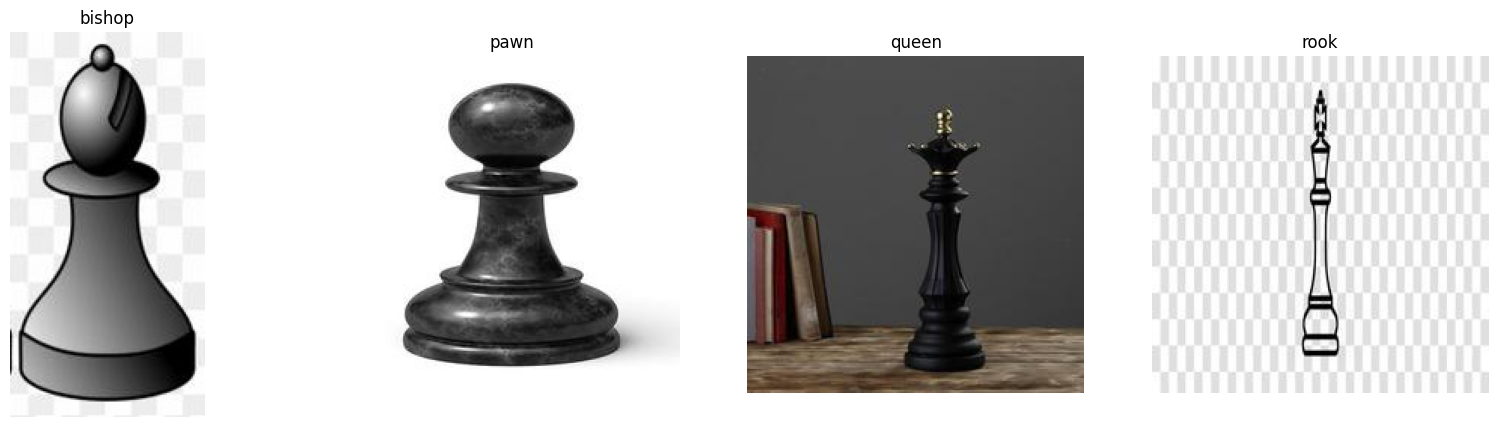

In [39]:
data_dir = "pices_db/data_real"


# bishop_images = get_images_for_subpath("bishop_resized")
# knight_images = get_images_for_subpath("knight_resized")
# pawn_images = get_images_for_subpath("pawn_resized")
# queen_images = get_images_for_subpath("queen_resized")
# rook_images = get_images_for_subpath("rook_resized")

bishop_images = get_images_for_subpath(data_dir, "bishop_resized_224", )
knight_images = get_images_for_subpath( data_dir, "knight_resized_224")
pawn_images = get_images_for_subpath(data_dir, "pawn_resized_224")
# king_images = get_images_for_subpath("king")
queen_images = get_images_for_subpath(data_dir, "queen_resized_224")
rook_images = get_images_for_subpath(data_dir, "rook_resized_224")

# create a dataframe with the images and their labels
df_real = pd.DataFrame({'image': np.concatenate([bishop_images, knight_images, pawn_images, queen_images, rook_images]),
                   'label': ['bishop']*len(bishop_images) + ['knight']*len(knight_images) + ['pawn']*len(pawn_images) + ['queen']*len(queen_images) + ['rook']*len(rook_images)})
print(df_real.head(10))
display_df(df_real)

We see that this dataset is quite messy, the images are varied in background and style, and do not match our usecase of a computer chess game.
Also note that this dataset does not have images of kings...

Let's take a look at the second dataset  

                                image   label
0  pices_db\data_icons\bishop\100.png  bishop
1  pices_db\data_icons\bishop\101.png  bishop
2   pices_db\data_icons\bishop\34.png  bishop
3   pices_db\data_icons\bishop\35.png  bishop
4   pices_db\data_icons\bishop\36.png  bishop
5   pices_db\data_icons\bishop\37.png  bishop
6   pices_db\data_icons\bishop\38.png  bishop
7   pices_db\data_icons\bishop\39.png  bishop
8   pices_db\data_icons\bishop\40.png  bishop
9   pices_db\data_icons\bishop\41.png  bishop
[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=85x85 at 0x17C27F173D0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=85x85 at 0x17C279A9CD0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=85x85 at 0x17C27943650>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=85x85 at 0x17C2799C090>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=85x85 at 0x17C2799FF10>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=85x85 at 0x17C27EDA9D0>]


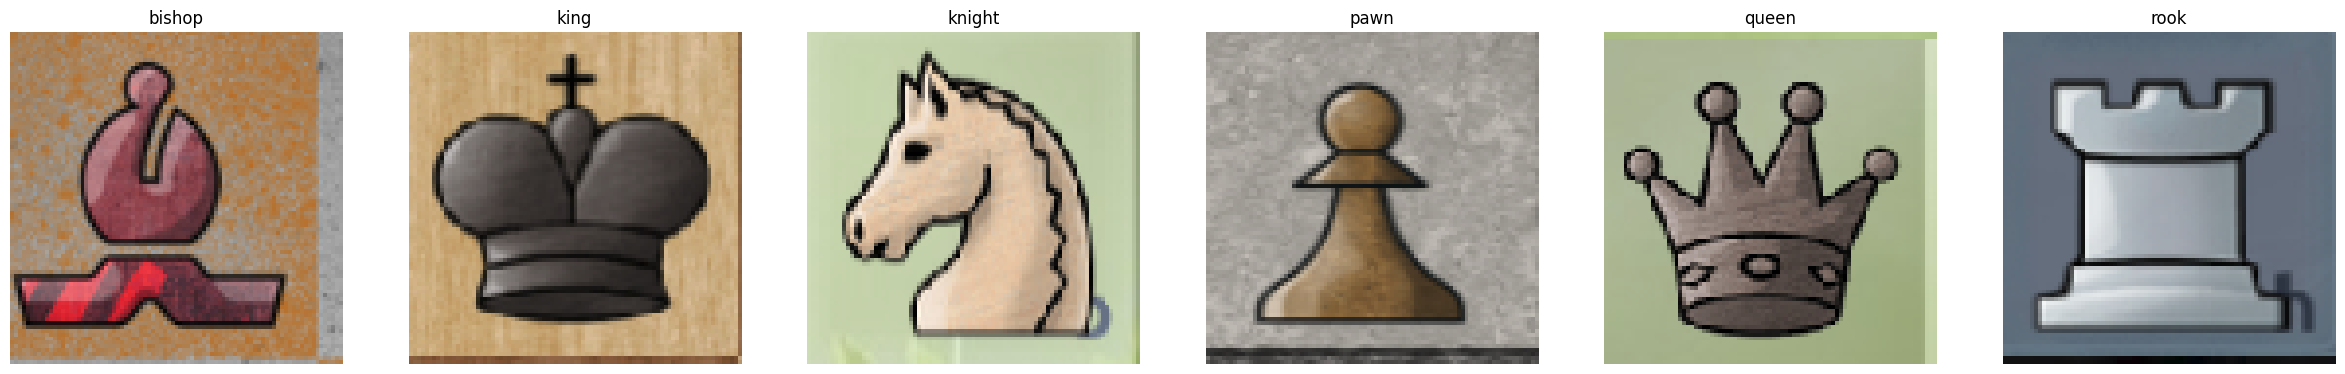

In [40]:
data_dir = "pices_db/data_icons"


bishop_images = get_images_for_subpath(data_dir, "bishop")
knight_images = get_images_for_subpath(data_dir, "knight")
pawn_images = get_images_for_subpath(data_dir, "pawn")
king_images = get_images_for_subpath(data_dir, "king")
queen_images = get_images_for_subpath(data_dir, "queen")
rook_images = get_images_for_subpath(data_dir, "rook")

# create a dataframe with the images and their labels
df = pd.DataFrame({'image': np.concatenate([bishop_images, knight_images, pawn_images, king_images, queen_images, rook_images]),
                   'label': ['bishop']*len(bishop_images) + ['knight']*len(knight_images) + ['pawn']*len(pawn_images) + ['king']*len(king_images) + ['queen']*len(queen_images) + ['rook']*len(rook_images)})
print(df.head(10))
display_df(df)

This dataset matches our needs better, as the images are infact icons of chess pieces.
let's split the data into train and test, and try to apply a simple supervised SVM classification model 

In [41]:
df.to_csv('pices_db/mainframe.csv', index=False)

In [50]:
from sklearn.model_selection import train_test_split
# get 0.8 of each label for training and 0.2 for validation
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(train.head(10))
print(test.head(10))


                                  image   label
210    pices_db\data_icons\pawn\278.png    pawn
108  pices_db\data_icons\knight\486.png  knight
340    pices_db\data_icons\pawn\408.png    pawn
87   pices_db\data_icons\knight\465.png  knight
24    pices_db\data_icons\bishop\56.png  bishop
493    pices_db\data_icons\rook\150.png    rook
348    pices_db\data_icons\pawn\416.png    pawn
76   pices_db\data_icons\knight\454.png  knight
242    pices_db\data_icons\pawn\310.png    pawn
360    pices_db\data_icons\pawn\428.png    pawn
                                  image   label
266    pices_db\data_icons\pawn\334.png    pawn
149    pices_db\data_icons\pawn\218.png    pawn
346    pices_db\data_icons\pawn\414.png    pawn
136  pices_db\data_icons\knight\515.png  knight
480    pices_db\data_icons\rook\137.png    rook
258    pices_db\data_icons\pawn\326.png    pawn
323    pices_db\data_icons\pawn\391.png    pawn
297    pices_db\data_icons\pawn\365.png    pawn
362    pices_db\data_icons\pawn\430.png 

In [51]:
def count_labels(df):
    return df['label'].value_counts()
count_labels(train), count_labels(test)

(label
 pawn      191
 knight     57
 rook       57
 bishop     54
 queen      27
 king       27
 Name: count, dtype: int64,
 label
 pawn      48
 rook      15
 knight    14
 bishop    13
 king       7
 queen      7
 Name: count, dtype: int64)

In [52]:
def get_images(image_paths):
    return np.array([Image.open(p) for p in image_paths])

x_train = get_images(train['image'])
y_train = np.array(train['label'])
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = get_images(test['image'])
y_test = np.array(test['label'])
x_test = x_test.reshape(x_test.shape[0], -1)


In [53]:

def do_svm(x_train, y_train, x_test, y_test): 
    model = SVC(kernel='linear', C=1E9)
    print("[+] training model")
    model.fit(x_train,y_train)
    print("[+] testing model")
    result = model.predict(x_test)
    mask = result==y_test
    correct = np.count_nonzero(mask)
    print (correct*100.0/result.size)
    return model

model_1 = do_svm(x_train, y_train, x_test, y_test)


[+] training model
[+] testing model
83.65384615384616


We see that a naive applience of SVM provides decent results, at 83%. 
This is not optimal, perhaps because we do not have many samples of the images, and they are varied in color and background.
To remove these features, we will try to provide the model with a HOG representation of the image, which will eliminate the color and background features. 


In [55]:
def get_images_gs(image_paths):
    return np.array([cv2.imread(p,  cv2.IMREAD_GRAYSCALE) for p in image_paths])

x_train_gs = get_images_gs(train['image'])
y_train_gs = np.array(train['label'])
x_train_gs = x_train_gs.reshape(x_train_gs.shape[0], -1)
x_test_gs = get_images_gs(test['image'])
y_test_gs = np.array(test['label'])
x_test_gs = x_test_gs.reshape(x_test_gs.shape[0], -1)
model_gs = do_svm(x_train_gs, y_train_gs, x_test_gs, y_test_gs)


[+] training model
[+] testing model
83.65384615384616


In [67]:
def canny(img):
    t_lower = 60  # Lower Threshold 
    t_upper = 200  # Upper threshold 
    aperture_size = 3  # Aperture size 
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_canny = cv2.Canny(img_gray, t_lower, t_upper,  
                 apertureSize=aperture_size, L2gradient =True) 
    return img_canny

def get_images_canny(image_paths):
    return np.array([canny(cv2.imread(p)) for p in image_paths])

x_train_c = get_images_canny(train['image'])
y_train_c = np.array(train['label'])
x_train_c = x_train_c.reshape(x_train_c.shape[0], -1)
x_test_c = get_images_canny(test['image'])
y_test_c = np.array(test['label'])
x_test_c = x_test_c.reshape(x_test_c.shape[0], -1)
model_canny = do_svm(x_train_c, y_train_c, x_test_c, y_test_c)


[+] training model
[+] testing model
88.46153846153847


We see that a canny filter improves the detection chances but they are still not optimal. 
Let's try HOG feature extraction, which might improve on Canny.

In [66]:
# do some HOG processing on the images so it will be better
import cv2
def hog(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    win_size = img_gray.shape
    # resize image to be multiple of 8 
    win_size = (win_size[1] - win_size[1] % 8, win_size[0] - win_size[0] % 8)
    img_gray = cv2.resize(img_gray, win_size)
    cell_size = (8, 8)
    block_size = (16, 16)
    block_stride = (8, 8)
    num_bins = 9
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)
    hog_descriptor = hog.compute(img)
    return hog_descriptor
    # cv2.HOGDescriptor(win_size=(64, 128),
    #               block_size=(16, 16),
    #               block_stride=(8, 8),
    #               cell_size=(8, 8),
    #               nbins=9,
    #               win_sigma=DEFAULT_WIN_SIGMA,
    #               threshold_L2hys=0.2,
    #               gamma_correction=true,
    #               nlevels=DEFAULT_NLEVELS)
    # bin_n = 16
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0)
    # gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1)
    # mag, ang = cv2.cartToPolar(gx, gy)
    # bins = np.int32(bin_n * ang/(2*np.pi))
    # bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    # mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    # hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells,
    # mag_cells)]
    # hist = np.hstack(hists)
    # return hist


def get_images_hog(image_paths):
    return np.array([hog(cv2.imread(p)) for p in image_paths])
    # return np.array([Image.open(p) for p in image_paths])

x_train_h = get_images_hog(train['image'])
y_train_h = np.array(train['label'])
x_train_h = x_train_h.reshape(x_train_h.shape[0], -1)
x_test_h = get_images_hog(test['image'])
y_test_h = np.array(test['label'])
x_test_h = x_test_h.reshape(x_test_h.shape[0], -1)
model_hog = do_svm(x_train_h, y_train_h, x_test_h, y_test_h)



[+] training model
[+] testing model
100.0


We see that using HOG feature extraction yields very good results!
        

### Another method - no preprocessing
For the research purposes, let's try to use a pre trained model and fine-tune it to our dataset.
As the input to this model, we will give the original image without edge detection or other such preprocessing, and see what the model can do. 

In [14]:
# until now we got a 84%~ accuracy with the SVM learning on unmanipulated images
# let's try to use a pre-trained model with fine tuning to get better results
from transformers import ViTImageProcessor
import torch
model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

c:\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce GTX 1650 is available.


In [16]:
# train_images = get_images(train['image'])
# processor(train_images, return_tensors='pt')
import evaluate
import datasets
def vit_transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([Image.open(x) for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = example_batch['label']
    return inputs

train_hf = datasets.Dataset.from_pandas(train)
prepared_ds_train =  train_hf.with_transform(vit_transform)
test_hf = datasets.Dataset.from_pandas(test)
prepared_ds_test =  test_hf.with_transform(vit_transform)

labels = list(set(train_hf['label']))
labels_to_ids = {label: i for i, label in enumerate(labels)}
ids_to_labels = {i: label for label, i in labels_to_ids.items()}
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([labels_to_ids[x['label']] for x in batch])
    }
metric = evaluate.load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


In [17]:
from transformers import ViTForImageClassification

# labels = train_hf.features['label'].names
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"got labels - {labels}")
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label=ids_to_labels,
    label2id=labels_to_ids
)
model.to(device)

got labels - ['knight', 'king', 'queen', 'rook', 'pawn', 'bishop']


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [18]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-chess",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

c:\Python\Python311\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds_train,
    eval_dataset=prepared_ds_test,
    tokenizer=processor,
)

In [20]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

  0%|          | 0/104 [00:00<?, ?it/s]c:\Python\Python311\Lib\site-packages\transformers\models\vit\modeling_vit.py:261: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
 10%|▉         | 10/104 [01:04<09:19,  5.96s/it]

{'loss': 1.4022, 'grad_norm': 1.5529154539108276, 'learning_rate': 0.00018076923076923077, 'epoch': 0.38}


 19%|█▉        | 20/104 [02:04<08:09,  5.82s/it]

{'loss': 0.6631, 'grad_norm': 1.093721866607666, 'learning_rate': 0.00016153846153846155, 'epoch': 0.77}


 29%|██▉       | 30/104 [03:00<06:49,  5.54s/it]

{'loss': 0.2925, 'grad_norm': 0.8787147402763367, 'learning_rate': 0.0001423076923076923, 'epoch': 1.15}


 38%|███▊      | 40/104 [03:56<05:57,  5.58s/it]

{'loss': 0.2233, 'grad_norm': 1.7901793718338013, 'learning_rate': 0.0001230769230769231, 'epoch': 1.54}


 48%|████▊     | 50/104 [04:52<05:04,  5.63s/it]

{'loss': 0.1452, 'grad_norm': 0.42619234323501587, 'learning_rate': 0.00010384615384615386, 'epoch': 1.92}


 58%|█████▊    | 60/104 [05:47<04:04,  5.56s/it]

{'loss': 0.1033, 'grad_norm': 0.3171345591545105, 'learning_rate': 8.461538461538461e-05, 'epoch': 2.31}


 67%|██████▋   | 70/104 [06:44<03:10,  5.60s/it]

{'loss': 0.0876, 'grad_norm': 0.45715948939323425, 'learning_rate': 6.538461538461539e-05, 'epoch': 2.69}


 77%|███████▋  | 80/104 [07:39<02:11,  5.50s/it]

{'loss': 0.0861, 'grad_norm': 0.2754431366920471, 'learning_rate': 4.615384615384616e-05, 'epoch': 3.08}


 87%|████████▋ | 90/104 [08:36<01:19,  5.66s/it]

{'loss': 0.0765, 'grad_norm': 0.23977750539779663, 'learning_rate': 2.6923076923076923e-05, 'epoch': 3.46}


 96%|█████████▌| 100/104 [09:33<00:22,  5.68s/it]

{'loss': 0.068, 'grad_norm': 0.22177550196647644, 'learning_rate': 7.692307692307694e-06, 'epoch': 3.85}


                                                 
 96%|█████████▌| 100/104 [09:47<00:22,  5.68s/it]

{'eval_loss': 0.11474638432264328, 'eval_accuracy': 0.9711538461538461, 'eval_runtime': 13.9996, 'eval_samples_per_second': 7.429, 'eval_steps_per_second': 0.929, 'epoch': 3.85}


100%|██████████| 104/104 [12:29<00:00,  7.20s/it]


{'train_runtime': 749.1449, 'train_samples_per_second': 2.205, 'train_steps_per_second': 0.139, 'train_loss': 0.30511270692715275, 'epoch': 4.0}
***** train metrics *****
  epoch                    =         4.0
  total_flos               = 119229179GF
  train_loss               =      0.3051
  train_runtime            =  0:12:29.14
  train_samples_per_second =       2.205
  train_steps_per_second   =       0.139


In [21]:
metrics = trainer.evaluate(prepared_ds_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

100%|██████████| 13/13 [00:18<00:00,  1.46s/it]

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9712
  eval_loss               =     0.1147
  eval_runtime            = 0:00:20.07
  eval_samples_per_second =      5.179
  eval_steps_per_second   =      0.647


We got a decent accuracy of 97%, and this is without any pre-processing of our image!
We can see that this type of model is stronger in our case, and for this assignment we will use it. 

In [23]:
# now that we have tested and trained the model, we need to use it for running the predictionima
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# test_image_6_7.png should be a pawn 
inputs = processor([np.array(Image.open('analyzed/test_image_6_7.png'), dtype=np.float16)], return_tensors='pt').to(device) 
print(inputs)
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_idx = logits.argmax(-1).item()
predicted_label = model.config.id2label[predicted_class_idx]
print(predicted_class_idx, predicted_label)

{'pixel_values': tensor([[[[-0.1294, -0.1294, -0.1294,  ..., -0.5843, -0.6549, -0.6549],
          [-0.1294, -0.1294, -0.1294,  ..., -0.5843, -0.6549, -0.6549],
          [-0.1216, -0.1216, -0.1216,  ..., -0.5843, -0.6549, -0.6549],
          ...,
          [ 0.2627,  0.2627,  0.2627,  ..., -0.5608, -0.6863, -0.6863],
          [ 0.3647,  0.3647,  0.3647,  ..., -0.5529, -0.6941, -0.6941],
          [ 0.3647,  0.3647,  0.3647,  ..., -0.5529, -0.6941, -0.6941]],

         [[ 0.1373,  0.1373,  0.1373,  ..., -0.5922, -0.7020, -0.7020],
          [ 0.1373,  0.1373,  0.1373,  ..., -0.5922, -0.7020, -0.7020],
          [ 0.1451,  0.1451,  0.1451,  ..., -0.5922, -0.7020, -0.7020],
          ...,
          [ 0.4196,  0.4196,  0.4196,  ..., -0.5686, -0.7176, -0.7176],
          [ 0.4980,  0.4980,  0.4980,  ..., -0.5608, -0.7255, -0.7255],
          [ 0.4980,  0.4980,  0.4980,  ..., -0.5608, -0.7255, -0.7255]],

         [[-0.3804, -0.3804, -0.3804,  ..., -0.6471, -0.6863, -0.6863],
          [-0

In [24]:
# Define a function to use later in the identification process
def identify_chess_piece(model, images):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # test_image_6_7.png should be a pawn 
    inputs = processor(images, return_tensors='pt').to(device) 
    # print(inputs)
    with torch.no_grad():
        logits = model(**inputs).logits

    predicted_class_idx = logits.argmax(-1).item()
    predicted_label = model.config.id2label[predicted_class_idx]
    return predicted_label


## Conclusion
We see that if we are willing to use prepcoressing, we can achive very good results with a relativly light-weighted model (SVM).
If we find the preprocessing to expensive or problematic to implement in real-world scenarios, we can instead use a find-tuned version of a pre-trained classification model.
